# **clusTCR comparison with other TCR clustering methods**
This notebook compares the performance of clusTCR with existing TCR clustering methods.

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from clusTCR.clusTCR import Clustering, Metrics
from clusTCR.datasets import vdj_cdr3_small, vdj_gliph2_small, vdj_epitopes_small, vdj_tcrdist_small
from clusTCR.gliph2 import GLIPH2
from clusTCR.ismart import iSMART
from clusTCR.import_functions import path_in_data
from tcrdist.repertoire import TCRrep
from sklearn.cluster import DBSCAN

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.)

## **1. Speed comparison**

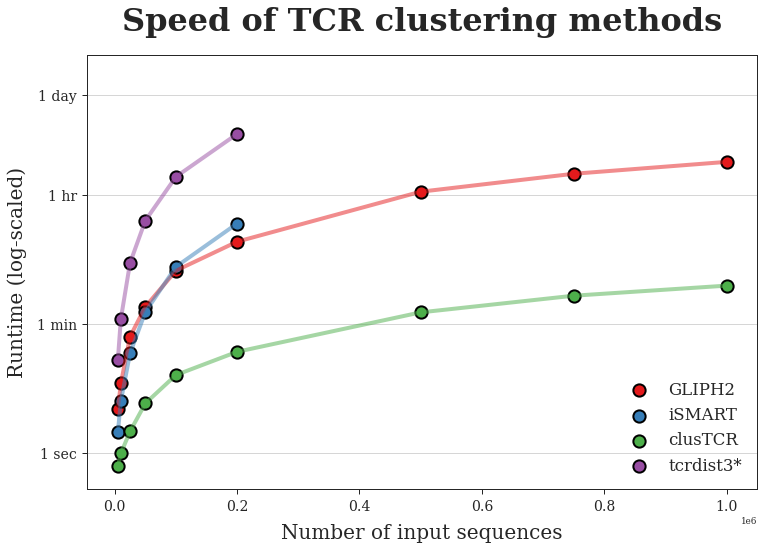

In [35]:
data = pd.read_csv('./results/method_comparison_speed.tsv', sep = '\t')
data = data[data['n_sequences']<=10**6]
methods = data.columns[:-1]
n_seq = data[data.columns[-1]]
colors = ['tab:blue', 'tab:orange', '']

fig, ax = plt.subplots(figsize=(12,8))
for method in methods:
    ax.scatter(n_seq, y = np.log10(data[method]), 
               marker = 'o', 
               s = 150, 
               linewidths = 2, 
               edgecolors = 'black', 
               label = method,
               zorder = 1)
    ax.plot(n_seq, np.log10(data[method]), 
            alpha = .5, 
            lw = 4,
            zorder = 2,)

ax.set_title('Speed of TCR clustering methods', fontsize = 32, fontweight = 'bold', y=1.04)
ax.set_xlabel('Number of input sequences', fontsize = 20, labelpad = 10)
ax.set_ylabel('Runtime (log-scaled)', fontsize = 20, labelpad = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'xx-large')

locs = np.log10([1,60,3600,86400])
labels = ["1 sec", "1 min", "1 hr", "1 day"]
plt.ylim((-0.5,5.5))
plt.yticks(ticks=locs, labels=labels)
plt.grid(axis='y')

# fig.savefig('../results/figures/method_comparison_speed_log.png')
# fig.savefig('../results/figures/method_comparison_speed_log.eps', format='eps')

## **2. Accuracy comparison**

### *2.1. Calculate metrics*

In [15]:
results = []

# Different quality subsets of VDJdb
qscore = [0, 1, 2]
for q in qscore:
    
    # Data
    epitopes = vdj_epitopes_small(q = q)
    data_gliph2 = vdj_gliph2_small(q = q)
    data_cdr3 = vdj_cdr3_small(q = q)
    data_td = vdj_tcrdist_small(q = q)
    
    # GLIPH2
    GLIPH2(data_gliph2, os.path.abspath('../src/clusTCR/modules/gliph2/'))
    gliph2_output = pd.read_csv(path_in_data('methods/GLIPH2_{}.tsv'.format(len(data_gliph2))), sep='\t')
    gliph2_metrics = Metrics(gliph2_output, epitopes, name='GLIPH2')
    summ_gliph2 = gliph2_metrics.summary()
    
    # iSMART
    iSMART(data_cdr3, os.path.abspath('../src/clusTCR/modules/ismart/'))
    ismart_output = pd.read_csv(path_in_data('methods/iSMART_{}.tsv'.format(len(data_cdr3))), sep='\t')
    ismart_metrics = Metrics(ismart_output, epitopes, name='iSMART')
    summ_ismart = ismart_metrics.summary()
    
    # clusTCR
    twostep = Clustering(data_cdr3, method = 'two-step', n_cpus=8)
    ts_output = twostep.get_clusters()
    ts_metrics = Metrics(ts_output, epitopes, name='clusTCR')
    summ_ts = ts_metrics.summary()
    
    # tcrdist3
    if q != 0:
        print('pw dist calculations for {} sequences with tcrdist.'.format(len(data_td)))
        tr = TCRrep(cell_df = data_td,
                    organism = 'human',
                    chains = ['beta'],
                    db_file='alphabeta_gammadelta_db.tsv')
        d = tr.pw_cdr3_b_aa
        clustering = DBSCAN(eps=18, min_samples=2, n_jobs=-1).fit(d)
        labels = clustering.labels_
        data_td['cluster'] = labels
        data_td = data_td[data_td['cluster']!=-1]
        data_td.rename(columns={'cdr3_b_aa':'CDR3','v_b_gene':'V'}, inplace=True)
        td_metrics = Metrics(data_td, epitopes, name='tcrdist3')
        summ_td = td_metrics.summary()
    else:
        summ_td = pd.DataFrame({'actual':[None, None, None, None], 
                                'baseline':[None, None, None, None], 
                                'metrics':['retention', 'purity', 'purity_90', 'consistency'],
                                'method':['tcrdist3+DBSCAN']*4})
                               
    summ_total = pd.concat([summ_gliph2, summ_ismart, summ_ts, summ_td])
    summ_total['q'] = [q] * len(summ_total)
    results.append(summ_total)
                               
summary = pd.concat(results)
summary.to_csv('../results/method_comparison_accuracy.tsv', sep = '\t', index = False)

Clustering 26679 sequences with GLIPH2.
Elapsed time: 53.947280406951904 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_26679.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 24981 sequences with iSMART.
Elapsed time: 27.477491855621338 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_24981.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 3403 sequences with GLIPH2.
Elapsed time: 5.1609227657318115 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_3403.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 2851 sequences with iSMART.
Elapsed time: 0.9944150447845459 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_2851.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


pw dist calculations for 3403 sequences with tcrdist.


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 594 sequences with GLIPH2.
Elapsed time: 2.613055944442749 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_594.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 495 sequences with iSMART.
Elapsed time: 0.28023242950439453 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_495.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


pw dist calculations for 594 sequences with tcrdist.


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


### 2.2. Plot results

In [5]:
data = pd.read_csv('../results/method_comparison_accuracy.tsv', sep = '\t')

def plot_metric(data, metric, title=None, y_label=None):
    
    metric_data = data[data['metrics']==metric]

    fig, ax = plt.subplots(figsize=(12,8))

    for method in metric_data.method.unique():

        m = metric_data[metric_data['method']==method]
        x = m.q
        y_a = m.actual
        y_b = m.baseline

        ax.scatter(x, y_a, marker='D', s=150, label=method)
        ax.plot(x, y_a, alpha=0.3, lw=4, ls='--')

    if title is not None:
        ax.set_title(title, fontsize = 24)
    else:
        ax.set_title('{} of TCR clustering approaches'.format(metric), fontsize = 24)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize = 18)
    else:
        ax.set_ylabel('{}'.format(metric), fontsize = 18)
    ax.set_xlabel('VDJdb subset', fontsize = 18, labelpad=20)
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=18)
    # ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.legend(fontsize = 'xx-large')

    locs = [0, 1, 2]
    labels = ['All', 'Q $\geq$ 1', 'Q $\geq$ 2']
    plt.xticks(ticks=locs, labels=labels)
    plt.grid(axis='y')
    
    plt.show()
    fig.savefig("../results/figures/method_comparison_{}.eps".format(metric), format="eps")

#### *2.2.1. Retention*
Retention is calculated as the number of sequences that end up in any cluster, relative to the total number of input sequences.

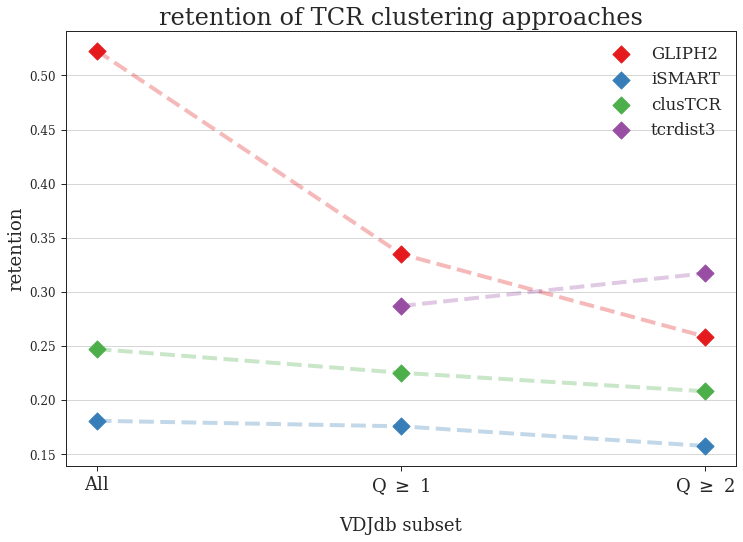

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
plot_metric(data, 'retention')

#### *2.2.2 Purity*
Purity describes the fraction of sequences within a cluster targeting the same epitope.

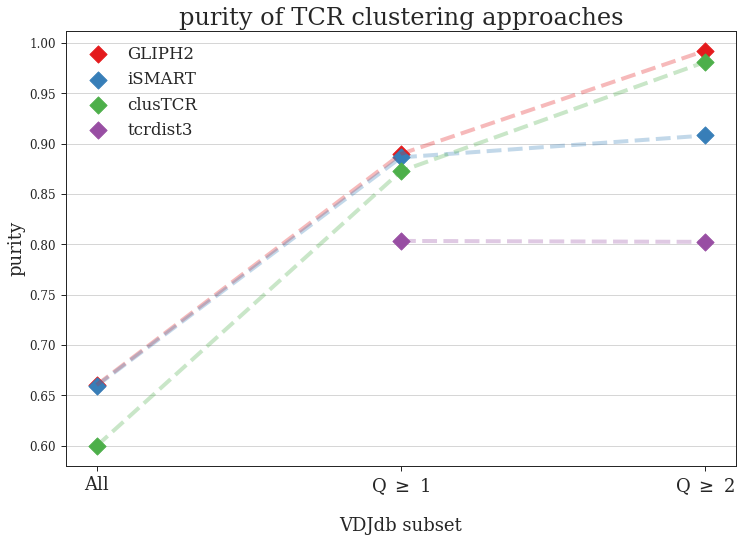

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
plot_metric(data, 'purity')

#### *2.2.3 Purity_90*
Fraction of clusters with purity > 90%.

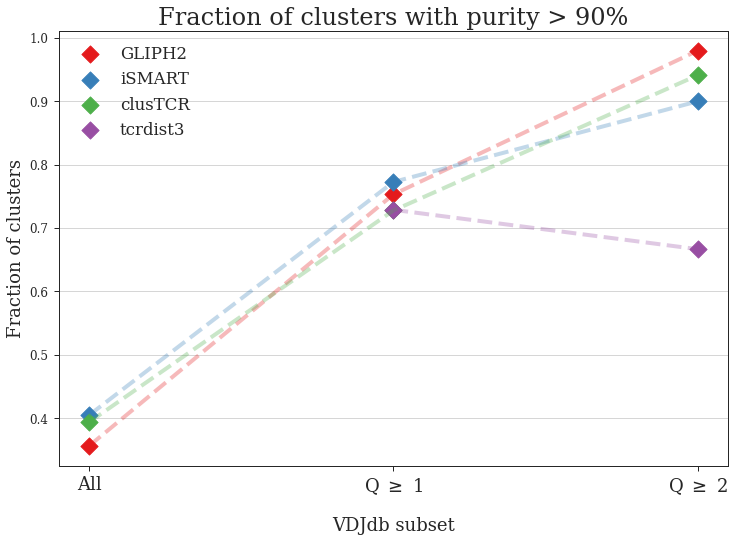

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
plot_metric(data, 'purity_90', 'Fraction of clusters with purity > 90%', 'Fraction of clusters')

#### *2.2.4 Consistency*
Consistency describes the fraction of sequences targeting the same epitope that are assigned to the same cluster.

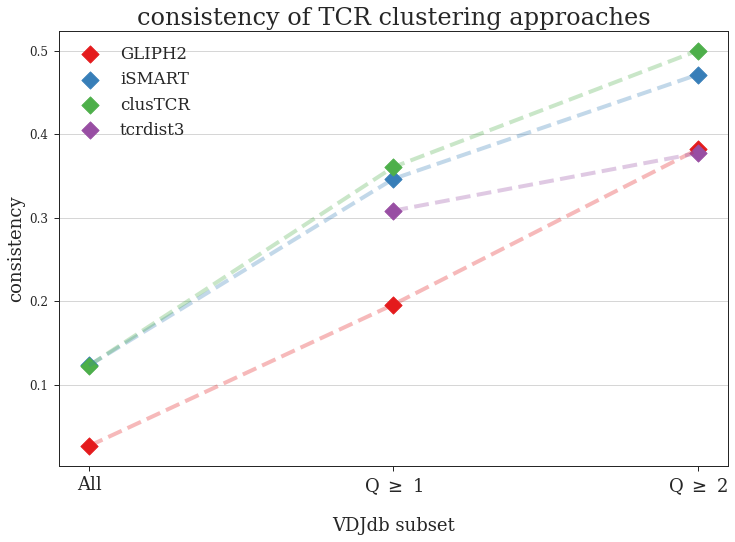

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
plot_metric(data, 'consistency')